In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aminehfar","key":"2d4f6af9b6786be61ec95dd320c3d7d2"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset -p /content
!unzip -q /content/brain-tumor-mri-dataset.zip -d /content/brain_tumor

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
  0% 0.00/149M [00:00<?, ?B/s]
100% 149M/149M [00:00<00:00, 2.40GB/s]


In [4]:
import os
print(os.listdir("/content/brain_tumor"))


['Training', 'Testing']


In [5]:
data_dir = "/content/brain_tumor"
print(os.listdir(data_dir))        # ['Training', 'Testing']
print(os.listdir(f"{data_dir}/Training"))  # ['glioma', 'meningioma', 'notumor', 'pituitary']


['Training', 'Testing']
['pituitary', 'meningioma', 'notumor', 'glioma']


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import os


In [7]:
# ---- Config ----
DATA_DIR = "/content/brain_tumor"
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 5
LR = 1e-3
NUM_WORKERS = 2

In [8]:
# ===========================
# 1. Device setup
# ===========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [9]:
# ===========================
# 2. Data transforms
# ===========================
train_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

eval_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [10]:
# ===============================
# 3. Dataset + DataLoader
# ==============================
DATA_DIR = "/content/brain_tumor"  # path

train_ds = datasets.ImageFolder(os.path.join(DATA_DIR, "Training"), transform=train_tfms)
#val_ds   = datasets.ImageFolder(os.path.join(DATA_DIR, "val"), transform=eval_tfms)
test_ds  = datasets.ImageFolder(os.path.join(DATA_DIR, "Testing"), transform=eval_tfms)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
#val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

num_classes = len(train_ds.classes)
print("Classes:", train_ds.classes)

Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [12]:
# ===========================
# 4. Load pretrained ResNet-50
# ===========================
model = models.resnet50(pretrained=True)

# Freeze feature extractor (optional: unfreeze later for fine-tuning)
for param in model.parameters():
    param.requires_grad = False

# Replace final layer with your classifier
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)

model = model.to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 199MB/s]


In [13]:
# ===========================
# 5. Loss + Optimizer
# ===========================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)

In [14]:
# ===========================
# 6. Training loop
# ===========================
def train(model, train_loader, val_loader, epochs=5):
    for epoch in range(epochs):
        # ---- Train ----
        model.train()
        train_loss, train_correct = 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * x.size(0)
            train_correct += (out.argmax(1) == y).sum().item()

        train_loss /= len(train_ds)
        train_acc = train_correct / len(train_ds)

        # ---- Validation ----
        model.eval()
        test_loss, test_correct = 0, 0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)

                test_loss += loss.item() * x.size(0)
                test_correct += (out.argmax(1) == y).sum().item()

        test_loss /= len(test_ds)
        test_acc = test_correct / len(test_ds)

        print(f"Epoch {epoch+1}/{epochs}: "
              f"Train Loss={train_loss:.4f}, Acc={train_acc:.4f} | "
              f"Val Loss={test_loss:.4f}, Acc={test_acc:.4f}")

# Train the model
train(model, train_loader, test_loader, epochs=5)



Epoch 1/5: Train Loss=0.6147, Acc=0.7770 | Val Loss=0.5010, Acc=0.8047
Epoch 2/5: Train Loss=0.4143, Acc=0.8477 | Val Loss=0.4335, Acc=0.8345
Epoch 3/5: Train Loss=0.3706, Acc=0.8682 | Val Loss=0.4164, Acc=0.8391
Epoch 4/5: Train Loss=0.3388, Acc=0.8743 | Val Loss=0.4163, Acc=0.8360
Epoch 5/5: Train Loss=0.3404, Acc=0.8738 | Val Loss=0.3287, Acc=0.8703


In [15]:
# ===========================
# 7. Test accuracy
# ===========================
def evaluate(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            preds = out.argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    print(f"Test Accuracy: {correct/total:.4f}")

evaluate(model, test_loader)


Test Accuracy: 0.8703


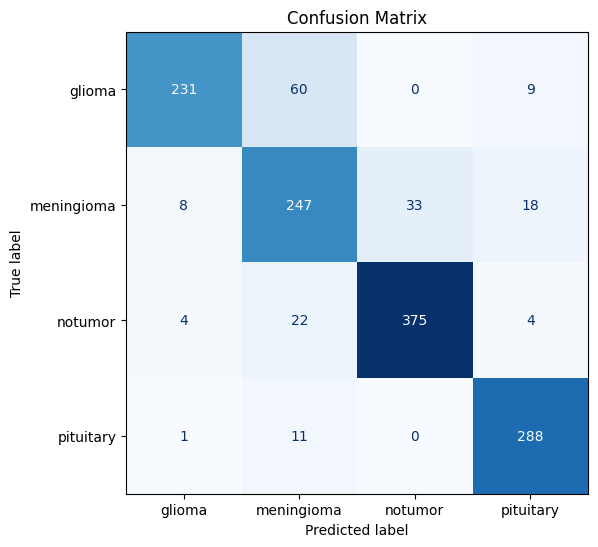

In [16]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, loader, class_names):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            preds = outputs.argmax(1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    # Plot
    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(ax=ax, cmap="Blues", values_format="d", colorbar=False)
    plt.title("Confusion Matrix")
    plt.show()

# Usage (after training, use validation or test loader)
plot_confusion_matrix(model, test_loader, train_ds.classes)
